## 0. Install Dependecies

In [1]:
pip install torch

**Import libraries**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin

Set Random seed

In [3]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)  # Python random module
np.random.seed(seed)  # NumPy
torch.manual_seed(seed)  # PyTorch

# If you're using GPU, set the deterministic flag
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

**Set device to GPU if is available otherwise set device as cpu**

In [4]:
import torch
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


##1. Dataset##

- The Datatset used in this project was generated using the Mujoco simulator with three different configurations:
- 2D (2 joints)
- 2D (3 joints)
- 3D (5 joints)

The format of the data is in CSV format, including information about Joint angles, fingertip position, and orientation.

This Notebook will focus on the 5DOF Robot dataset.


1.1. Visualise data from the simulator

In [5]:
!head -5 logfiler5.csv

j0;j1;j2;j3;j4;cos(j0);cos(j1);cos(j2);cos(j3);cos(j4);sin(j0);sin(j1);sin(j2);sin(j3);sin(j4);ft_x;ft_y;ft_z;ft_qw;ft_qx;ft_qy;ft_qz
 0.000;  0.000;  0.000;  0.000;  0.000;  1.000;  1.000;  1.000;  1.000;  1.000;  0.000;  0.000;  0.000;  0.000;  0.000;  0.000;  0.000;  0.590;  1.000;  0.000;  0.000;  0.000
 0.022; -0.005;  0.028;  0.016; -0.032;  1.000;  1.000;  1.000;  1.000;  0.999;  0.022; -0.005;  0.028;  0.016; -0.032;  0.011;  0.004;  0.590;  1.000; -0.016;  0.019;  0.011
 0.103;  0.005;  0.107;  0.017; -0.100;  0.995;  1.000;  0.994;  1.000;  0.995;  0.102;  0.005;  0.106;  0.017; -0.099;  0.041;  0.016;  0.587;  0.995; -0.053;  0.061;  0.054
 0.209;  0.067;  0.216;  0.013; -0.174;  0.978;  0.998;  0.977;  1.000;  0.985;  0.208;  0.067;  0.215;  0.013; -0.173;  0.100;  0.042;  0.573;  0.979; -0.101;  0.138;  0.116


1.2. Preprocess the data


2R Robot

In [24]:
# Load dataset
data = pd.read_csv('logfiler5.csv', delimiter=';')

# Preprocessing: Extract inputs (joint angles and their trigonometric functions) and outputs (fingertip positions and quaternions)
X = data[['j0', 'j1', 'j2', 'j3', 'j3','cos(j0)', 'cos(j1)', 'cos(j2)', 'cos(j3)', 'cos(j4)','sin(j0)', 'sin(j1)', 'sin(j2)', 'sin(j3)', 'sin(j4)']].values
y = data[['ft_x' ,'ft_y','ft_z' ,'ft_qw','ft_qx','ft_qy','ft_qz']].values

# Normalize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- Split the data into training and testing sets

In [25]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

##2. Train Forward Kinematics Models##



### 2.1. Robot 3DOF

- Define the architecture of the model (Feedforward Neural Network) to learn forward kinematics.




In [33]:
# Hyperparameters
hidden_size = 64
learning_rate = 0.001
num_epochs = 300

In [34]:
class ForwardKinematicsModel(nn.Module):
    def __init__(self, hidden_size, dropout_rate=0.3):
        super(ForwardKinematicsModel, self).__init__()
        # Define a feedforward network with configurable hidden_size and dropout
        self.fc1 = nn.Linear(15, hidden_size)  # Input layer
        self.dropout1 = nn.Dropout(p=dropout_rate)    # Dropout after first hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden layer
        self.dropout2 = nn.Dropout(p=dropout_rate)    # Dropout after second hidden layer
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Output layer
        self.dropout2 = nn.Dropout(p=dropout_rate)    # Dropout after second hidden layer
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # Output layer
        self.dropout2 = nn.Dropout(p=dropout_rate)    # Dropout after second hidden layer
        self.fc5 = nn.Linear(hidden_size, hidden_size)  # Output layer
        self.dropout2 = nn.Dropout(p=dropout_rate)    # Dropout after second hidden layer
        self.fc6 = nn.Linear(hidden_size, 7)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after first hidden layer
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after second hidden layer
        x = self.fc6(x)
        return x

## Train the model with the best 2 parameters found by grid search

- Train the models on joint angle inputs to predict fingertip positions.

- Define the loss function and optimizer

In [35]:
model = ForwardKinematicsModel(hidden_size=hidden_size)

In [36]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
# Convert to PyTorch tensors only if necessary
X_train = X_train.clone().detach().float() if isinstance(X_train, torch.Tensor) else torch.tensor(X_train, dtype=torch.float32)
y_train = y_train.clone().detach().float() if isinstance(y_train, torch.Tensor) else torch.tensor(y_train, dtype=torch.float32)
X_val = X_val.clone().detach().float() if isinstance(X_val, torch.Tensor) else torch.tensor(X_val, dtype=torch.float32)
y_val = y_val.clone().detach().float() if isinstance(y_val, torch.Tensor) else torch.tensor(y_val, dtype=torch.float32)
X_test = X_test.clone().detach().float() if isinstance(X_test, torch.Tensor) else torch.tensor(X_test, dtype=torch.float32)
y_test = y_test.clone().detach().float() if isinstance(y_test, torch.Tensor) else torch.tensor(y_test, dtype=torch.float32)

In [38]:
# Initialize variables for early stopping and visualization
best_val_loss = float('inf')
patience = 4
no_improvement_epochs = 0
best_model_path = "best_model_5DOF.pth"  # Path to save the best model

# Lists to store metrics for visualization
train_losses = []
val_losses = []
val_maes = []
val_r2_scores = []

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store train loss for visualization
    train_losses.append(loss.item())

    # Evaluate on validation set
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())  # Store validation loss

            # Calculate additional metrics
            mae = mean_absolute_error(y_val.numpy(), val_outputs.numpy())
            r2 = r2_score(y_val.numpy(), val_outputs.numpy())
            val_maes.append(mae)  # Store validation MAE
            val_r2_scores.append(r2)  # Store validation R^2

            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
                  f"MAE: {mae:.4f}, R^2: {r2:.4f}")

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_epochs = 0
                # Save the best model
                torch.save(model.state_dict(), best_model_path)
                print(f"Model saved at epoch {epoch+1} with Val Loss: {val_loss:.4f}")
            else:
                no_improvement_epochs += 1

            if no_improvement_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
                break  # Exit the training loop early

        model.train()  # Switch back to training mode

Epoch [10/300], Train Loss: 0.1270, Val Loss: 0.1126, MAE: 0.2715, R^2: -0.0087
Model saved at epoch 10 with Val Loss: 0.1126
Epoch [20/300], Train Loss: 0.1045, Val Loss: 0.0891, MAE: 0.2401, R^2: 0.1584
Model saved at epoch 20 with Val Loss: 0.0891
Epoch [30/300], Train Loss: 0.0890, Val Loss: 0.0727, MAE: 0.2167, R^2: 0.2959
Model saved at epoch 30 with Val Loss: 0.0727
Epoch [40/300], Train Loss: 0.0784, Val Loss: 0.0600, MAE: 0.1952, R^2: 0.4175
Model saved at epoch 40 with Val Loss: 0.0600
Epoch [50/300], Train Loss: 0.0700, Val Loss: 0.0500, MAE: 0.1767, R^2: 0.5127
Model saved at epoch 50 with Val Loss: 0.0500
Epoch [60/300], Train Loss: 0.0634, Val Loss: 0.0425, MAE: 0.1622, R^2: 0.5851
Model saved at epoch 60 with Val Loss: 0.0425
Epoch [70/300], Train Loss: 0.0578, Val Loss: 0.0362, MAE: 0.1483, R^2: 0.6460
Model saved at epoch 70 with Val Loss: 0.0362
Epoch [80/300], Train Loss: 0.0530, Val Loss: 0.0317, MAE: 0.1382, R^2: 0.6884
Model saved at epoch 80 with Val Loss: 0.0317

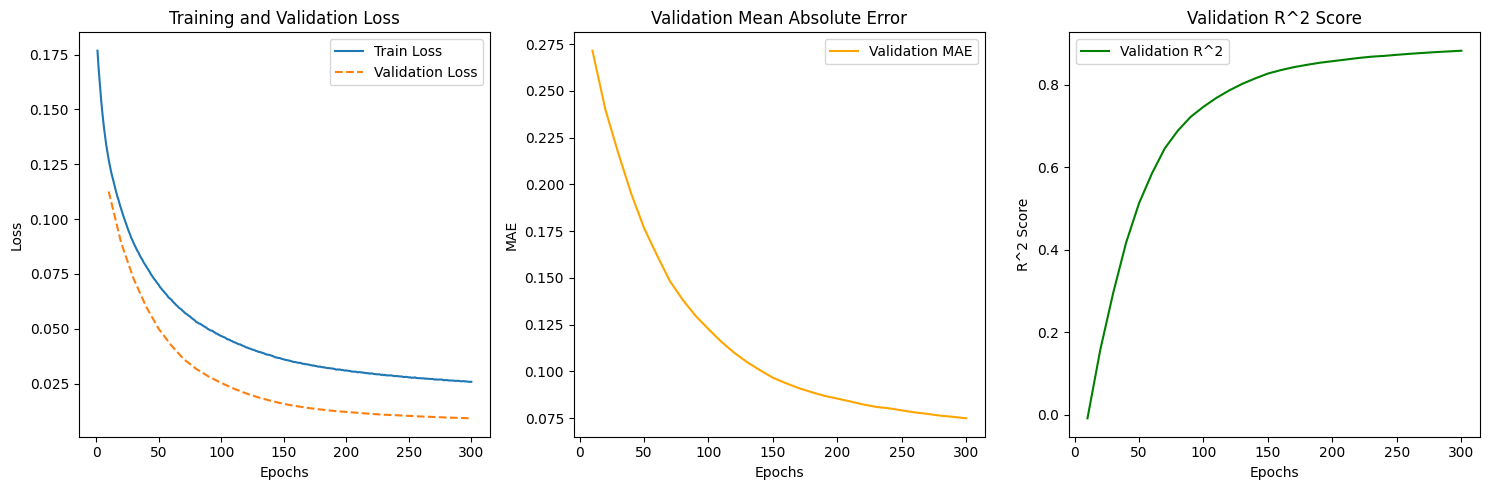

In [39]:
# Visualization
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(15, 5))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(range(10, len(val_losses)*10 + 1, 10), val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot validation MAE
plt.subplot(1, 3, 2)
plt.plot(range(10, len(val_maes)*10 + 1, 10), val_maes, label="Validation MAE", color="orange")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Validation Mean Absolute Error")
plt.legend()

# Plot validation R^2
plt.subplot(1, 3, 3)
plt.plot(range(10, len(val_r2_scores)*10 + 1, 10), val_r2_scores, label="Validation R^2", color="green")
plt.xlabel("Epochs")
plt.ylabel("R^2 Score")
plt.title("Validation R^2 Score")
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
# Test the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    mae_test = mean_absolute_error(y_test.numpy(), test_outputs.numpy())
    r2_test = r2_score(y_test.numpy(), test_outputs.numpy())

    print(f"Test Loss: {test_loss.item():.4f}")
    print(f"Test MAE: {mae_test:.4f}")
    print(f"Test R^2: {r2_test:.4f}")


Test Loss: 0.0091
Test MAE: 0.0745
Test R^2: 0.8829


##3. Compare Jacobians##



3.1. Compute the Jacobian matrix for the learned forward kinematics using automatic differentiation.



In [41]:
X_test = X_test.clone().detach().float() if isinstance(X_test, torch.Tensor) else torch.tensor(X_test, dtype=torch.float32)
y_test = y_test.clone().detach().float() if isinstance(y_test, torch.Tensor) else torch.tensor(y_test, dtype=torch.float32)

In [42]:
# Assuming X_test is a tensor and you want to extract the first sample
X_test_sample = X_test[0].clone().detach().unsqueeze(0).float()  # Add batch dimension and detach
print(X_test_sample)

tensor([[ 0.4621,  0.7712, -0.4779,  0.4935,  0.4935,  1.1237,  0.4981,  1.0481,
          1.0244, -0.9845,  0.6120,  0.9494, -0.6374,  0.6558, -1.2163]])


In [43]:
# Load the best model after training
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded for further evaluation or inference.")

Best model loaded for further evaluation or inference.


<ipython-input-43-e99125239d63>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [60]:
def compute_5dof_jacobian(model, inputs):
    # Ensure input gradients are enabled
    if not inputs.requires_grad:
        inputs.requires_grad = True

    # Forward pass
    outputs = model(inputs)

    # Select outputs of interest: ft_x, ft_y, ft_z
    ft_x, ft_y, ft_z = outputs[0], outputs[1], outputs[2]

    # Initialize the 2x5 Jacobian matrix as a PyTorch tensor
    jacobian = torch.zeros(2, 5, device=inputs.device)

    # Compute gradients for ft_x with respect to all inputs
    grad_ft_x = torch.autograd.grad(ft_x, inputs, retain_graph=True, create_graph=True)[0]
    jacobian[0, 0] = grad_ft_x[0]  # ∂ft_x/∂j0
    jacobian[0, 1] = grad_ft_x[1]  # ∂ft_x/∂j1
    jacobian[0, 2] = grad_ft_x[2]  # ∂ft_x/∂j2
    jacobian[0, 3] = grad_ft_x[3]  # ∂ft_x/∂j3
    jacobian[0, 4] = grad_ft_x[4]  # ∂ft_x/∂j4

    # Compute gradients for ft_y with respect to all inputs
    grad_ft_y = torch.autograd.grad(ft_y, inputs, retain_graph=True, create_graph=True)[0]
    jacobian[1, 0] = grad_ft_y[0]  # ∂ft_y/∂j0
    jacobian[1, 1] = grad_ft_y[1]  # ∂ft_y/∂j1
    jacobian[1, 2] = grad_ft_y[2]  # ∂ft_y/∂j2
    jacobian[1, 3] = grad_ft_y[3]  # ∂ft_y/∂j3
    jacobian[1, 4] = grad_ft_y[4]  # ∂ft_y/∂j4

    return jacobian

3.2. Compare the computed Jacobian with the analytical Jacobian for the 2-joint robot.

In [52]:
# Analytical Jacobian for a 5-DOF robot
def analytical_jacobian_5dof(data):
    # Extract joint angles from data
    j0 = data[0]  # Joint 0
    j1 = data[1]  # Joint 1
    j2 = data[2]  # Joint 2
    j3 = data[3]  # Joint 3
    j4 = data[4]  # Joint 4

    # Link lengths (modify based on the actual robot dimensions)
    l1 = 1.0  # Link 1 length
    l2 = 1.0  # Link 2 length
    l3 = 1.0  # Link 3 length
    l4 = 1.0  # Link 4 length
    l5 = 1.0  # Link 5 length

    # Calculate the Jacobian elements using the analytical formula
    J = np.array([
        # Partial derivatives of the x-coordinate (end-effector position) with respect to each joint
        [-l1 * np.sin(j0) - l2 * np.sin(j0 + j1) - l3 * np.sin(j0 + j1 + j2) - l4 * np.sin(j0 + j1 + j2 + j3) - l5 * np.sin(j0 + j1 + j2 + j3 + j4),
         -l2 * np.sin(j0 + j1) - l3 * np.sin(j0 + j1 + j2) - l4 * np.sin(j0 + j1 + j2 + j3) - l5 * np.sin(j0 + j1 + j2 + j3 + j4),
         -l3 * np.sin(j0 + j1 + j2) - l4 * np.sin(j0 + j1 + j2 + j3) - l5 * np.sin(j0 + j1 + j2 + j3 + j4),
         -l4 * np.sin(j0 + j1 + j2 + j3) - l5 * np.sin(j0 + j1 + j2 + j3 + j4),
         -l5 * np.sin(j0 + j1 + j2 + j3 + j4)],

        # Partial derivatives of the y-coordinate (end-effector position) with respect to each joint
        [l1 * np.cos(j0) + l2 * np.cos(j0 + j1) + l3 * np.cos(j0 + j1 + j2) + l4 * np.cos(j0 + j1 + j2 + j3) + l5 * np.cos(j0 + j1 + j2 + j3 + j4),
         l2 * np.cos(j0 + j1) + l3 * np.cos(j0 + j1 + j2) + l4 * np.cos(j0 + j1 + j2 + j3) + l5 * np.cos(j0 + j1 + j2 + j3 + j4),
         l3 * np.cos(j0 + j1 + j2) + l4 * np.cos(j0 + j1 + j2 + j3) + l5 * np.cos(j0 + j1 + j2 + j3 + j4),
         l4 * np.cos(j0 + j1 + j2 + j3) + l5 * np.cos(j0 + j1 + j2 + j3 + j4),
         l5 * np.cos(j0 + j1 + j2 + j3 + j4)]
    ])

    return J

- Compute Diference between jacobian one iteration

In [61]:
import numpy as np
import torch

#Numerical Jacobian (calculated by FK_Jacobian)
X_test_sample = torch.tensor([ 0.4621,  0.7712, -0.4779,  0.4935,  0.4935,  1.1237,  0.4981,  1.0481, 1.0244, -0.9845,  0.6120,  0.9494, -0.6374,  0.6558, -1.2163], requires_grad=True)
jacobian_numerical = compute_5dof_jacobian(model, X_test_sample)

# Analytical Jacobian (calculated using analytical formula)X_test_sample = [-3.0970, -2.6260, -0.9990, -0.8700, -0.0450, -0.4930] # Extract joint angles for comparison
X_test_sample = X_test_sample.detach().numpy()
J_analytical = analytical_jacobian_5dof(X_test_sample)

# Print both Jacobians
print("Numerical Jacobian (PyTorch):\n", jacobian_numerical)
print("Analytical Jacobian (2-DOF Robot):\n", J_analytical)

# Compare both Jacobians by calculating the difference
jacobian_difference = (jacobian_numerical.detach().numpy() - J_analytical)
print("Difference between Numerical and Analytical Jacobians:\n", jacobian_difference)

Numerical Jacobian (PyTorch):
 tensor([[-0.0339,  0.0422,  0.0347,  0.0276, -0.0101],
        [ 0.0696,  0.0187, -0.0174,  0.0112,  0.0043]], grad_fn=<CopySlices>)
Analytical Jacobian (2-DOF Robot):
 [[-4.00894478 -3.56311595 -2.61952931 -1.93394941 -0.98531222]
 [ 2.09984492  1.20472668  0.87360094  0.14560352 -0.17076261]]
Difference between Numerical and Analytical Jacobians:
 [[ 3.97507242  3.6053301   2.65421838  1.96151794  0.9751912 ]
 [-2.03024553 -1.18598366 -0.89097649 -0.13442245  0.17502919]]


- Compute diferences Full test set

In [62]:
# Initialize lists to store results
numerical_jacobians = []
analytical_jacobians = []
jacobian_differences = []

# Loop through the test set to compute the Jacobians and differences
for i in range(len(X_test)):
    # Get the current sample (convert to tensor and ensure requires_grad=True)
    X_test_sample = torch.tensor(X_test[i], dtype=torch.float32, requires_grad=True)

    # Compute the numerical Jacobian using the model
    jacobian_numerical = compute_5dof_jacobian(model, X_test_sample)

    # Compute the analytical Jacobian
    X_test_sample_np = X_test_sample.detach().numpy()
    J_analytical = analytical_jacobian_5dof(X_test_sample_np)

    # Calculate the difference between the Jacobians
    jacobian_difference = jacobian_numerical.detach().numpy() - J_analytical

    # Store the results
    numerical_jacobians.append(jacobian_numerical.detach().numpy())
    analytical_jacobians.append(J_analytical)
    jacobian_differences.append(jacobian_difference)

# Convert lists to numpy arrays for analysis
numerical_jacobians = np.array(numerical_jacobians)
analytical_jacobians = np.array(analytical_jacobians)
jacobian_differences = np.array(jacobian_differences)

# Calculate the mean difference
mean_difference = np.mean(np.abs(jacobian_differences), axis=(1, 2))  # Mean of absolute differences for each sample
mean_difference_overall = np.mean(mean_difference)  # Overall mean difference

# Calculate percentage of times analytical Jacobian is bigger or smaller
analytical_bigger = np.sum(np.linalg.norm(analytical_jacobians, axis=(1, 2)) > np.linalg.norm(numerical_jacobians, axis=(1, 2)))
analytical_smaller = np.sum(np.linalg.norm(analytical_jacobians, axis=(1, 2)) < np.linalg.norm(numerical_jacobians, axis=(1, 2)))
total = len(X_test)

percent_bigger = (analytical_bigger / total) * 100
percent_smaller = (analytical_smaller / total) * 100

# Print results
print(f"Mean difference between numerical and analytical Jacobians: {mean_difference_overall:.6f}")
print(f"Percentage of cases where analytical Jacobian is bigger: {percent_bigger:.2f}%")
print(f"Percentage of cases where analytical Jacobian is smaller: {percent_smaller:.2f}%")

<ipython-input-62-e2137a5b0e2d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_sample = torch.tensor(X_test[i], dtype=torch.float32, requires_grad=True)


Mean difference between numerical and analytical Jacobians: 1.328577
Percentage of cases where analytical Jacobian is bigger: 100.00%
Percentage of cases where analytical Jacobian is smaller: 0.00%
